In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
sys.path.append("..")

import torch
from omegaconf import OmegaConf
from prec_models import construct_model_class
from prec_models.sw_unet import SW_UNet, SW_Conv
model_list = [SW_UNet, SW_Conv]
model_classes = {cl.__name__: cl for cl in model_list}
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [3]:
logs_path = os.path.join(os.sep, "data", "data_data_assimilation", "log_dump", "SW")
exp_path = os.path.join(os.sep, "GNlearning", "SW")
artifacts_path = os.path.join(exp_path, "artifacts")

In [4]:
model_path = OmegaConf.load(os.path.join(artifacts_path, "mlflow_run_id.yaml"))['model_path']
rank = OmegaConf.load(os.path.join(artifacts_path, "mlflow_run_id.yaml"))
config = OmegaConf.load(os.path.join(os.path.dirname(model_path), 'config.yaml'))
print(f"{model_path=}")
print(f"{config=}")

model_path='/data/data_data_assimilation/shallow_water/tmp_model_storage/99a70803a40c4debbae9852f10397450/model.pth'
config={'model': {'dimension': 12160}, 'data': {'data_folder': '/data/data_data_assimilation/shallow_water/large', 'nsamples': 2000}, 'architecture': {'class': 'SW_UNet', 'rank': 1000, 'n_layers': 0, 'neurons_per_layer': 0, 'batch_size': 3, 'lr': 0.0001, 'n_rnd_vectors': 0}, 'optimizer': {'epochs': 50}, 'DA': {'n_cycle': 10, 'n_outer': 5, 'n_inner': 100, 'model_error_sqrt': 0.5, 'obs_error_sqrt': 3.0}, 'misc': {'mlflow': True}}


In [5]:
torch_model = construct_model_class(
    model_classes[config["architecture"]["class"]],
    rank=config["architecture"]["rank"],
)
state_dimension = config["model"]["dimension"]
model = torch_model(state_dimension=state_dimension, config=config["architecture"])

UNet: 1.062987972 Gb


In [6]:
model.load_state_dict(torch.load(model_path))
model.eval()

dummy(
  (layers): UNet(
    (activation): LeakyReLU(negative_slope=0.01)
    (pooling): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (dropout): Dropout(p=0.1, inplace=False)
    (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (norm1): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
    (enc_layers1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
      (2): LeakyReLU(negative_slope=0.01)
      (3): Dropout(p=0.1, inplace=False)
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): LayerNorm((64, 64, 64), eps=1e-05, elementwise_affine=True)
      (6): LeakyReLU(negative_slope=0.01)
      (7): Dropout(p=0.1, inplace=False)
    )
    (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (e21): Conv2d(64, 128, kernel_siz

In [7]:
eta_slice = slice(None, 64**2)
u_slice = slice(64**2, 64**2 + 63*64)
v_slice = slice(64**2 + 64*63, None)

def get_control_2D(state):
    n_batch = state.shape[0]
    return (
        state[:, eta_slice].reshape(n_batch, 64, 64),
        state[:, u_slice].reshape(n_batch, 63, 64),
        state[:, v_slice].reshape(n_batch, 64, 63),
    )

In [8]:
data = np.load('/data/data_data_assimilation/shallow_water/large/gn_data_0033.npy')
state = data[:, 0]

In [9]:
def plot_state(state, figsize=(12, 6)):
    eta, u, v = get_control_2D(state.reshape(-1, state_dimension))
    fig = plt.figure(figsize=figsize)

    ax1 = fig.add_subplot(131)
    im1 = ax1.imshow(eta.squeeze().T)
    divider = make_axes_locatable(ax1)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im1, cax=cax, orientation='vertical')

    ax2 = fig.add_subplot(132)
    im2 = ax2.imshow(u.squeeze().T)
    divider = make_axes_locatable(ax2)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im2, cax=cax, orientation='vertical')

    ax3 = fig.add_subplot(133)
    im3 = ax3.imshow(v.squeeze().T)
    divider = make_axes_locatable(ax3)
    cax = divider.append_axes('right', size='5%', pad=0.05)
    fig.colorbar(im3, cax=cax, orientation='vertical')

    plt.tight_layout()

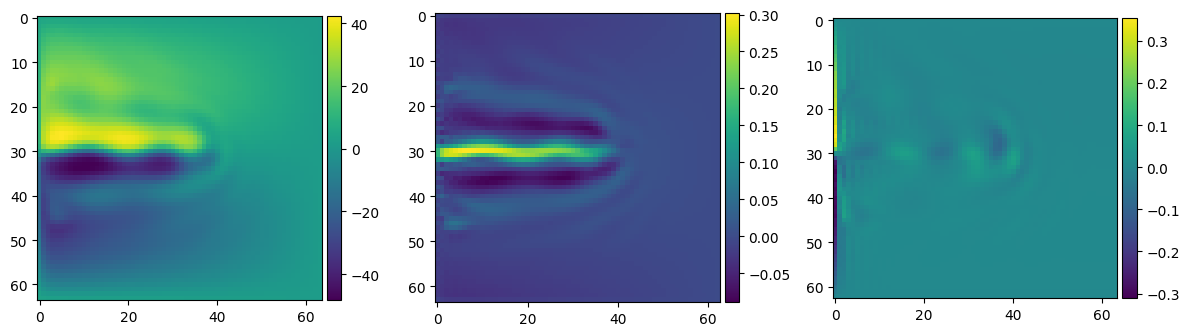

In [10]:
plot_state(data[:, 0])

In [11]:
def inference_model(state):
    if len(state.shape) == 1:
        state = state.reshape(-1, state_dimension)
        A_approx, singular_values, _vectors = model.to("cuda").construct_approx(
            torch.tensor(state, device="cuda")
        )
        singular_values = singular_values.cpu().detach().numpy().squeeze()
        sorted_idx = np.argsort(singular_values)[::-1]
        singular_values = singular_values[sorted_idx]
        _vectors = _vectors.squeeze().cpu().detach().numpy()[:, sorted_idx]
        vectors = np.linalg.qr(_vectors)[0]
        return A_approx, singular_values, vectors, _vectors

In [12]:
len(state.shape ) > 1

False

In [13]:
data = np.load('/data/data_data_assimilation/shallow_water/large/gn_data_0000.npy')
state = data[:, 0]
A_approx, singular_values, vectors, _vecs1 = inference_model(state)
data2 = np.load('/data/data_data_assimilation/shallow_water/large/gn_data_0500.npy')
state2 = data2[:, 0]
A_approx2, singular_values2, vectors2, _vecs2 = inference_model(state2)

In [14]:
# model()
traced_model = model.to_torchscript()
#example_inputs = torch.tensor(state).reshape(-1, state_dimension)

RuntimeError: 

aten::reshape(Tensor(a) self, SymInt[] shape) -> Tensor(a):
Expected a value of type 'int' for argument '<varargs>' but instead found type 'float'.
:
  File "/GNlearning/SW/../prec_models/sw_unet.py", line 204
    def forward(self, x):
        x = self.forward_unet(x)
        x = x.reshape(-1, int(self.rank), 3 * 64**2)
            ~~~~~~~~~ <--- HERE
        outputs = self.final_dense_layer(x).transpose(-1, -2)
        vecs, vals = outputs[:, :-1, :], outputs[:, -1, :]


In [61]:
# print(traced_model.graph)
print(traced_model.code)

def forward(self,
    x: Tensor) -> Tensor:
  layers = self.layers
  n_batch = ops.prim.NumToTensor(torch.size(x, 0))
  _0 = int(n_batch)
  n_batch0 = ops.prim.NumToTensor(torch.size(x, 0))
  _1 = int(n_batch0)
  _2 = int(n_batch0)
  _3 = int(n_batch0)
  _4 = torch.slice(x, 0, 0, 9223372036854775807)
  eta = torch.reshape(torch.slice(_4, 1, 0, 4096), [_3, 64, 64])
  _5 = torch.slice(x, 0, 0, 9223372036854775807)
  u = torch.reshape(torch.slice(_5, 1, 4096, 8128), [_2, 63, 64])
  _6 = torch.slice(x, 0, 0, 9223372036854775807)
  _7 = torch.slice(_6, 1, 8128, 9223372036854775807)
  v = torch.reshape(_7, [_1, 64, 63])
  out_vec = torch.empty([_0, 3, 64, 64], dtype=None, layout=None, device=torch.device("cuda"), pin_memory=False)
  _8 = torch.div(eta, CONSTANTS.c0)
  _9 = torch.slice(out_vec, 0, 0, 9223372036854775807)
  _10 = torch.slice(torch.select(_9, 1, 0), 1, 0, 9223372036854775807)
  _11 = torch.slice(_10, 2, 0, 9223372036854775807)
  _12 = torch.copy_(_11, _8)
  _13 = torch.slice(ou

In [30]:
states = np.vstack([state, state2])
# out = inference_model(states)


In [64]:
scripted_module = torch.jit.script(model)
torch.jit.save(scripted_module, 'mymodule.pt', )

RuntimeError: UNet is not attached to a `Trainer`.

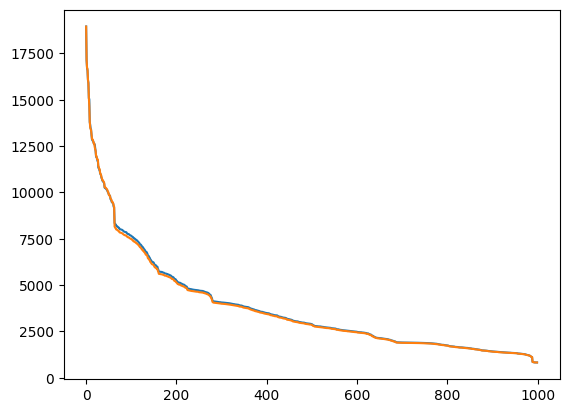

In [32]:
plt.plot(singular_values)
plt.plot(singular_values2)

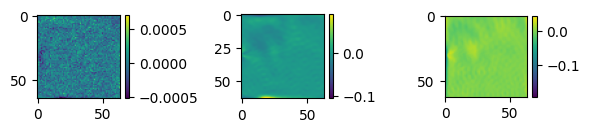

<Figure size 640x480 with 0 Axes>

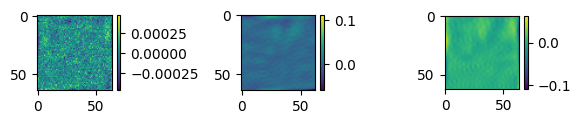

<Figure size 640x480 with 0 Axes>

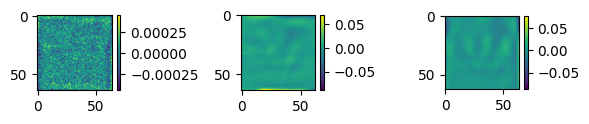

<Figure size 640x480 with 0 Axes>

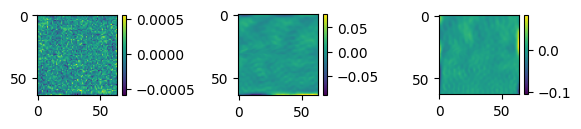

<Figure size 640x480 with 0 Axes>

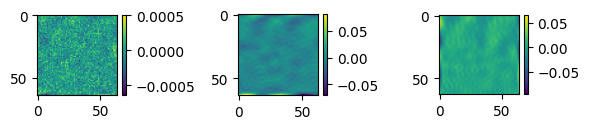

<Figure size 640x480 with 0 Axes>

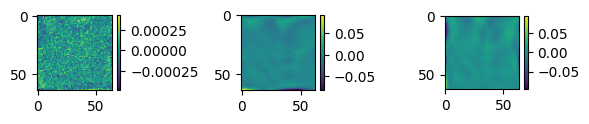

<Figure size 640x480 with 0 Axes>

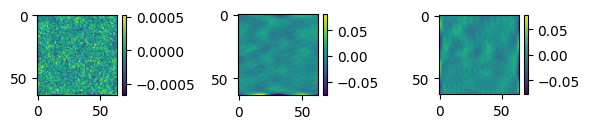

<Figure size 640x480 with 0 Axes>

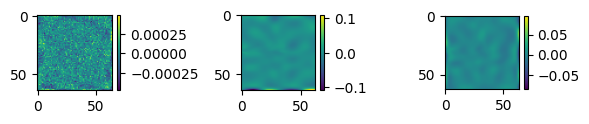

<Figure size 640x480 with 0 Axes>

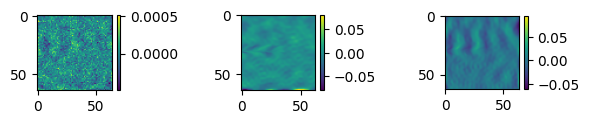

<Figure size 640x480 with 0 Axes>

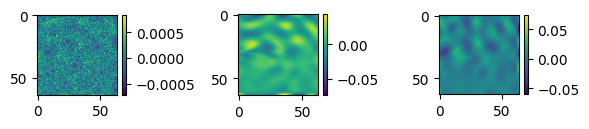

<Figure size 640x480 with 0 Axes>

In [36]:
for idx in range(10):
    plot_state(vectors[:, idx], figsize=(6, 4))
    plt.figure()

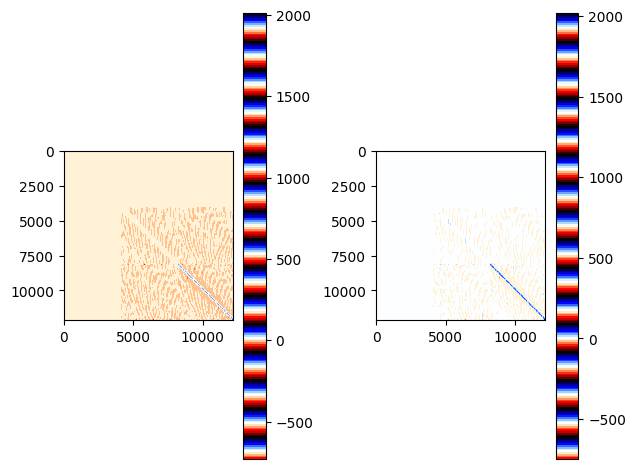

In [37]:
plt.subplot(1, 2, 1)
plt.imshow(A_approx.cpu().detach().numpy().squeeze(), cmap='flag')
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(A_approx2.cpu().detach().numpy().squeeze(), cmap='flag')
plt.colorbar()
plt.tight_layout()

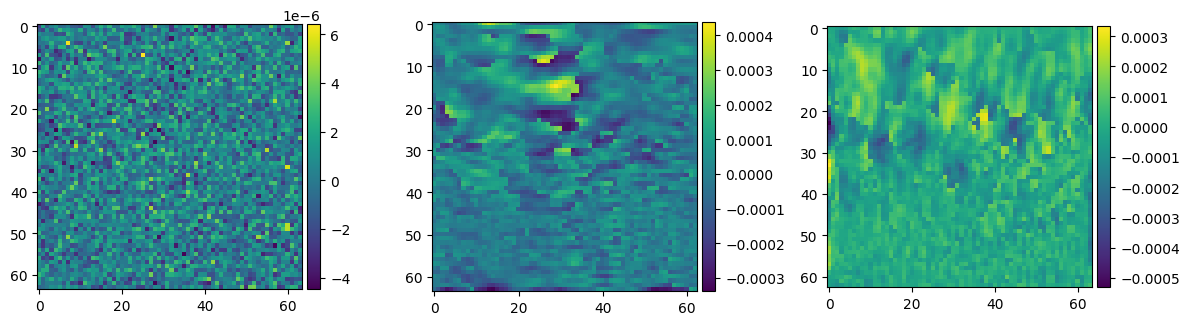

<Figure size 640x480 with 0 Axes>

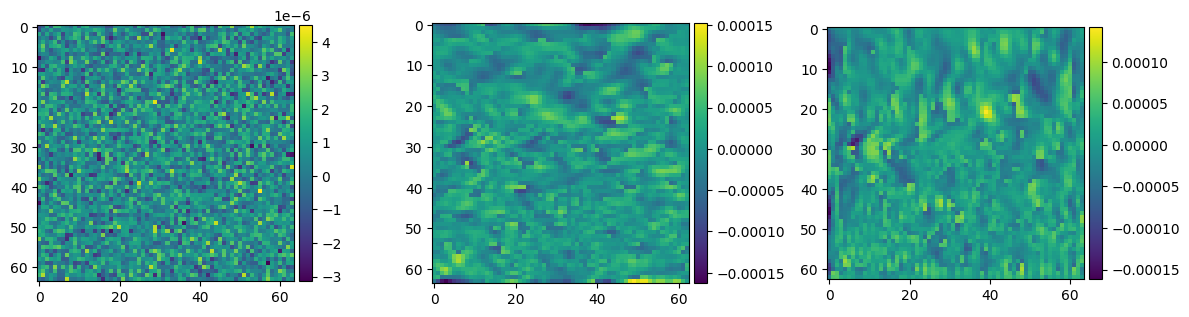

<Figure size 640x480 with 0 Axes>

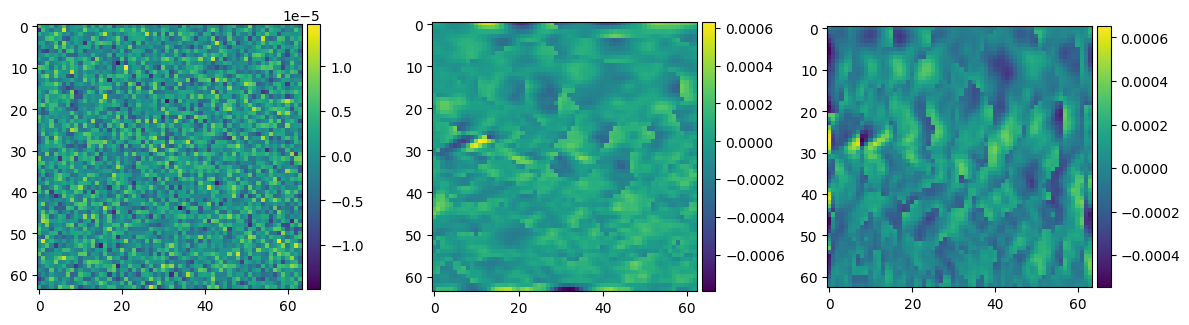

<Figure size 640x480 with 0 Axes>

In [38]:
for idx in range(3):
    plot_state(np.abs(vectors[:, idx])-np.abs(vectors2[:, idx]))
    plt.figure()